<a href="https://colab.research.google.com/github/SalaheddineAD/vision-transformer/blob/main/notebook/ViT_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.8 MB/s eta 0:00:00


In [2]:
pip install vit_keras

In [3]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.6 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow_addons.metrics import F1Score
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


from vit_keras import vit, utils

import time
import logging
import json
import os
import dill

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Enable tensorflow on gpu

In [5]:
!nvidia-smi

Thu Sep 21 22:14:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!gpu_enabled = True

/bin/bash: line 1: gpu_enabled: command not found


In [7]:
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)
# ! pip install tensorflow==2.5.0

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.13.0


In [8]:
import tensorflow as tf

# Check the number of available GPUs (optional)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set the GPU as the default device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Now, TensorFlow will use the GPU for all operations by default


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [9]:
def dump_json(data, json_file_path):
    with open(json_file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)

def load_json(json_file_path):
    with open(json_file_path, 'r') as json_file:
        loaded_data = json.load(json_file)
    return loaded_data

In [10]:
def save_model(model, file_path):
    os.makedirs(file_path, exist_ok=True)
    model.save(file_path)


def load_model(file_path):
    loaded_model = tf.keras.models.load_model(file_path)
    return loaded_model

In [11]:
def get_model_performance_metrics(model, images, labels):
    # Evaluating the model
    loss, accuracy = model.evaluate(images, labels)

    # Getting Precision, Recall, and F1 Score
    y_pred = model.predict(images)
    y_pred_labels = np.argmax(y_pred, axis=1)

    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, y_pred_labels, average='micro')

    performance = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }
    return performance

In [12]:
def save_model_logs(history,history_path):
    # saving logs
    logging.basicConfig(filename= history_path, level=logging.INFO)

    # Log training history
    for epoch, (loss, val_loss) in enumerate(zip(history.history['loss'], history.history['val_loss'])):
        logging.info(f"Epoch {epoch + 1}, Loss: {loss}, Val Loss {val_loss}")


In [13]:
def plot_log_function(history):
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [14]:
def random_transform(image):
    choice = random.randint(0, 5)

    rows, cols, _ = image.shape

    if choice == 0: # Translation
        tx, ty = random.randint(-20, 20), random.randint(-20, 20)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        return cv2.warpAffine(image, M, (cols, rows))

    elif choice == 1: # Rotation
        angle = random.randint(-30, 30)
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        return cv2.warpAffine(image, M, (cols, rows))

    elif choice == 2: # Scaling
        scale_factor = random.uniform(0.8, 1.2)
        new_rows, new_cols = int(rows * scale_factor), int(cols * scale_factor)
        return cv2.resize(image, (new_cols, new_rows))

    elif choice == 3: # Skewing
        pts1 = np.float32([[5,5],[20,5],[5,20]])
        pt1 = 5+10*np.random.uniform()-10/2
        pt2 = 20+10*np.random.uniform()-10/2
        pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
        M = cv2.getAffineTransform(pts1,pts2)
        return cv2.warpAffine(image, M, (cols, rows))

    elif choice == 4: # Perspective distortion
        pts1 = np.float32([[5,5],[20,5],[5,20],[20,20]])
        pts2 = np.float32([[0,0],[20,5],[5,20],[20,20]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        return cv2.warpPerspective(image, M, (cols, rows))

    else: # Pincushion distortion
        distortion = np.float32([1, 1, 0, 0])
        camera_matrix = np.eye(3)
        return cv2.undistort(image, camera_matrix, distortion)


In [15]:
def get_transformed_test_images(test_images):
    transformed_test_images = []
    for img in test_images:
        transformed_img = random_transform(img)
        transformed_test_images.append(transformed_img)

    # resizing transformed_test_images into (32, 32)
    new_shape = (32, 32)
    transformed_test_images = np.array([cv2.resize(img, new_shape).reshape(32, 32, 1) for img in transformed_test_images])

    # Checking for shape consistency

    good_shape = test_images[0].shape
    for i, img in enumerate(transformed_test_images):
        if img.shape != good_shape:
            print(f"Inconsistent shape at index {i}: expected {good_shape}, but got {img.shape}")
    return transformed_test_images

# 1 mnist dataset

In [16]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
seed = 42
np.random.seed(seed)

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Shuffle the training data and labels
shuffle_index_train = np.random.permutation(len(train_images))
train_images = train_images[shuffle_index_train]
train_labels = train_labels[shuffle_index_train]

# Shuffle the testing data and labels
shuffle_index_test = np.random.permutation(len(test_images))
test_images = test_images[shuffle_index_test]
test_labels = test_labels[shuffle_index_test]

11490434/11490434 [==============================] - 1s 0us/step


In [17]:
# Preprocess images
new_shape = (32, 32)
train_images = np.array([cv2.resize(img, new_shape) for img in train_images])
test_images = np.array([cv2.resize(img, new_shape) for img in test_images])

train_images, test_images = train_images / 255.0, test_images / 255.0
train_images = train_images[..., tf.newaxis].astype("float32")
test_images = test_images[..., tf.newaxis].astype("float32")

In [18]:
# creating validation images val_images
val_size = int(len(train_labels)*0.10)

train_images , val_images= train_images[val_size:], train_images[:val_size]
print("train_images size: ", train_images.shape, " and val_images size: ", val_images.shape)

train_labels , val_labels= train_labels[val_size:], train_labels[:val_size]
print("train_labels size: ", train_labels.shape, " and val_labels size: ", val_labels.shape)

train_images size:  (54000, 32, 32, 1)  and val_images size:  (6000, 32, 32, 1)
train_labels size:  (54000,)  and val_labels size:  (6000,)


## 1-1 Vision Transformer

In [19]:
# Build the ViT model

def create_vit_model(input_shape = (*new_shape, 1),  patch_size = 4, num_heads = 12, projection_dim = 32, num_transformer_layers = 12, mlp_head_units = [64, 32]):

    num_patches = (new_shape[0] // patch_size) * (new_shape[1] // patch_size)

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(3, (3, 3), padding="same")(inputs)  # Convert to 3 channels
    x = tf.keras.layers.Rescaling(1.0 / 255)(x)  # Rescale
    x = tf.keras.layers.Conv2D(32, (patch_size, patch_size), strides=patch_size)(x)
    x = tf.keras.layers.Reshape((num_patches, 32))(x)

    for _ in range(num_transformer_layers):
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = tf.keras.layers.Add()([attention_output, x])
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = tf.keras.layers.Conv1D(64, 2, padding="same", activation="relu")(x3)
        x3 = tf.keras.layers.Dropout(0.1)(x3)
        x3 = tf.keras.layers.Conv1D(32, 2, padding="same")(x3)
        x = tf.keras.layers.Add()([x3, x2])

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    for dim in mlp_head_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)


    model = tf.keras.Model(inputs, outputs)

    return model

In [20]:
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model
from vit_keras import vit
def build_vit_model(input_shape, num_classes=3):

  input_layer = Input(input_shape)
  replicated_channels = Concatenate(axis=-1)([input_layer] * 3)

  vit_model = vit.vit_b32(
      image_size=input_shape[0],
      activation='softmax',
      pretrained=True,
      include_top=True,
      pretrained_top=False,
      classes=num_classes)(replicated_channels)

  return Model(inputs=input_layer, outputs=vit_model)

In [21]:
# model = create_vit_model(input_shape = (*new_shape, 1),  patch_size = 4, num_heads = 2, projection_dim = 32, num_transformer_layers = 32, mlp_head_units = [64, 32])
model = build_vit_model((32,32,1), num_classes = 10)

353253686/353253686 [==============================] - 7s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 1, 1
  warnings.warn(


In [28]:
hyperparameters={
    "batch_size": 256,
    "epochs": 10,
    "optimizer":"adam",
    'early_stopping_patience':10,
    "learning_rate":0.001,
    "weight_decay" : 0.0001
}

def train_individual_model(model, train_images, train_labels, val_data, batch_size=hyperparameters['batch_size'], epochs=hyperparameters['epochs'], patience =hyperparameters['early_stopping_patience'], learning_rate= hyperparameters["learning_rate"], weight_decay = hyperparameters["weight_decay"] ):

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(optimizer=optimizer,

                  loss='sparse_categorical_crossentropy',

                  metrics=['accuracy'])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= patience, verbose=1, restore_best_weights=True)

    start_time = time.time()
    history = model.fit(train_images,train_labels, validation_data=val_data, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")

    # Using history to print training metrics
    print("\nTraining Metrics:")
    print(f"Loss: {history.history['loss'][-1]}")
    print(f"Accuracy: {history.history['accuracy'][-1]}")

    # Using history to print validation metrics
    print("\nValidation Metrics:")
    print(f"Loss: {history.history['val_loss'][-1]}")
    print(f"Accuracy: {history.history['val_accuracy'][-1]}")

    return history

In [29]:
history= train_individual_model(model, train_images,train_labels, val_data = (val_images, val_labels), batch_size=hyperparameters['batch_size'], epochs=hyperparameters['epochs'], patience =hyperparameters['early_stopping_patience'])

Epoch 1/10
211/211 [==============================] - 47s 146ms/step - loss: 0.0108 - accuracy: 0.9966 - val_loss: 0.0769 - val_accuracy: 0.9847
Epoch 2/10
211/211 [==============================] - 28s 134ms/step - loss: 0.0126 - accuracy: 0.9959 - val_loss: 0.0770 - val_accuracy: 0.9823
Epoch 3/10
211/211 [==============================] - 29s 136ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.0927 - val_accuracy: 0.9782
Epoch 4/10
211/211 [==============================] - 29s 136ms/step - loss: 0.0110 - accuracy: 0.9968 - val_loss: 0.0698 - val_accuracy: 0.9840
Epoch 5/10
211/211 [==============================] - 29s 138ms/step - loss: 0.0089 - accuracy: 0.9974 - val_loss: 0.0626 - val_accuracy: 0.9853
Epoch 6/10
211/211 [==============================] - 29s 138ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.0620 - val_accuracy: 0.9860
Epoch 7/10
211/211 [==============================] - 29s 139ms/step - loss: 0.0105 - accuracy: 0.9965 - val_loss: 0.0687 - val_ac

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
#saving model
path = os.path.join("/content/drive/My Drive/ML_research/experiments/",'vit_32_fine_tuned_mnist', 'model')
save_model(model, path)

In [ ]:
os.path.exists(os.path.join("/content/drive/My Drive/ML_research/experiments/",'vit_32_fine_tuned_mnist', 'model'))

True

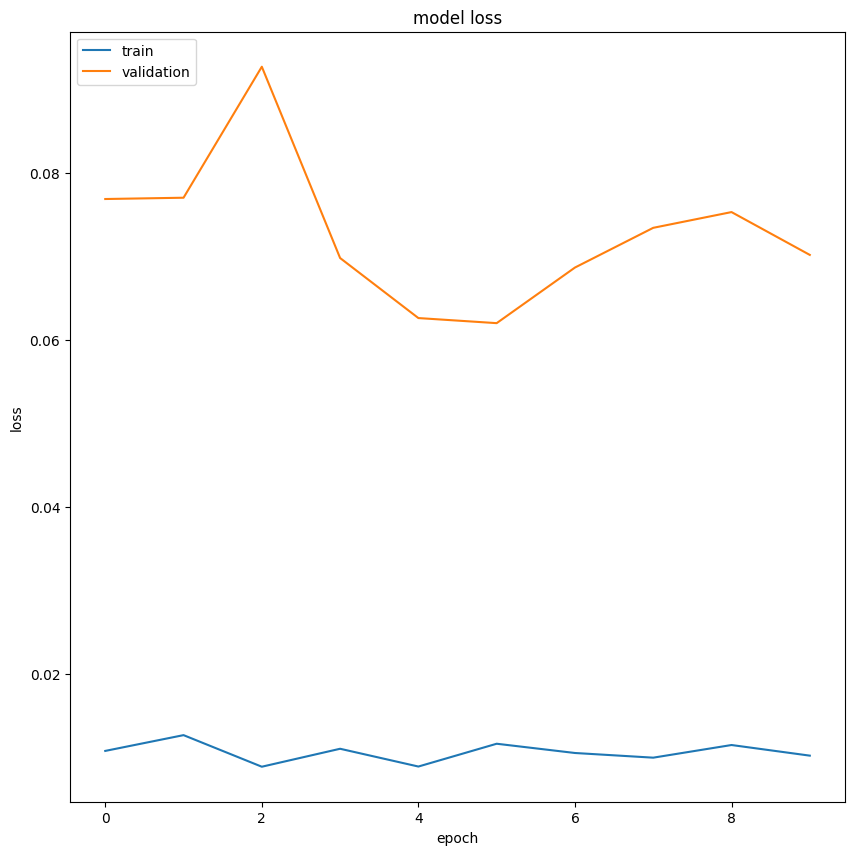

In [31]:
#checking the performance on taining_data
plot_log_function(history)

In [32]:
history_path = os.path.join("/content/drive/My Drive/ML_research/experiments/vit_32_fine_tuned_mnist", 'history.log')
save_model_logs(history,history_path)

In [33]:
path = os.path.join("/content/drive/My Drive/ML_research/experiments/",'vit_32_fine_tuned_mnist', 'model')

model2 = load_model(path)

In [34]:
# saving model architecture and hypermarameters
model_info = {
    "model_name": "ViT-32 pretrained"
}
model_info["hyperparameters"] = hyperparameters
model_info["model_architecture"] = model.to_json()
model_info["model_architecture"]  = json.loads(model_info["model_architecture"] )

path = os.path.join("/content/drive/My Drive/ML_research/experiments/",'vit_32_fine_tuned_mnist', 'model_architecture.json')
dump_json(model_info, path )
print(model_info)

{'model_name': 'ViT-32 pretrained', 'hyperparameters': {'batch_size': 256, 'epochs': 10, 'optimizer': 'adam', 'early_stopping_patience': 10, 'learning_rate': 0.001, 'weight_decay': 0.0001}, 'model_architecture': {'class_name': 'Functional', 'config': {'name': 'model', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 32, 32, 1], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 32, 1], [None, 32, 32, 1], [None, 32, 32, 1]]}, 'name': 'concatenate', 'inbound_nodes': [[['input_1', 0, 0, {}], ['input_1', 0, 0, {}], ['input_1', 0, 0, {}]]]}, {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'

In [35]:
load_json(os.path.join("/content/drive/My Drive/ML_research/experiments/",'vit_32_fine_tuned_mnist', 'model_architecture.json'))


{'model_name': 'ViT-32 pretrained',
 'hyperparameters': {'batch_size': 256,
  'epochs': 10,
  'optimizer': 'adam',
  'early_stopping_patience': 10,
  'learning_rate': 0.001,
  'weight_decay': 0.0001},
 'model_architecture': {'class_name': 'Functional',
  'config': {'name': 'model',
   'trainable': True,
   'layers': [{'module': 'keras.layers',
     'class_name': 'InputLayer',
     'config': {'batch_input_shape': [None, 32, 32, 1],
      'dtype': 'float32',
      'sparse': False,
      'ragged': False,
      'name': 'input_1'},
     'registered_name': None,
     'name': 'input_1',
     'inbound_nodes': []},
    {'module': 'keras.layers',
     'class_name': 'Concatenate',
     'config': {'name': 'concatenate',
      'trainable': True,
      'dtype': 'float32',
      'axis': -1},
     'registered_name': None,
     'build_config': {'input_shape': [[None, 32, 32, 1],
       [None, 32, 32, 1],
       [None, 32, 32, 1]]},
     'name': 'concatenate',
     'inbound_nodes': [[['input_1', 0, 0, {

In [36]:
transformed_test_images= get_transformed_test_images(test_images)

In [38]:
# #saving model performance metrics
# model_performance_metrics = {
#     "model_name": "ViT-32 pretrained"
# }
# model_performance_metrics["train_images_performance_metrics"] = get_model_performance_metrics(model,train_images, train_labels)
# model_performance_metrics["validation_images_performance_metrics"] = get_model_performance_metrics(model,val_images, val_labels)
# model_performance_metrics["test_images_performance_metrics"] = get_model_performance_metrics(model, test_images, test_labels)
# model_performance_metrics["transformed_test_images_performance_metrics"] = get_model_performance_metrics(model, transformed_test_images, test_labels)

performance_path = os.path.join("/content/drive/My Drive/ML_research/experiments/",'vit_32_fine_tuned_mnist', 'model_performance_metrics.json')
dump_json(model_performance_metrics, performance_path)
print(model_performance_metrics)

{'model_name': 'ViT-32 pretrained', 'train_images_performance_metrics': {'accuracy': 0.9985555410385132, 'precision': 0.9985555555555555, 'recall': 0.9985555555555555, 'f1_score': 0.9985555555555555}, 'validation_images_performance_metrics': {'accuracy': 0.9848333597183228, 'precision': 0.9848333333333333, 'recall': 0.9848333333333333, 'f1_score': 0.9848333333333333}, 'test_images_performance_metrics': {'accuracy': 0.9851999878883362, 'precision': 0.9852, 'recall': 0.9852, 'f1_score': 0.9852}, 'transformed_test_images_performance_metrics': {'accuracy': 0.605400025844574, 'precision': 0.6054, 'recall': 0.6054, 'f1_score': 0.6054}}
